In [7]:
# Import necessary libraries
from pathlib import Path
import json, random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
from PIL import Image

from IPython.display import display

# Configure Torch device
device = "cpu"
#device = "cuda" if torch.cuda_is_available() else "cpu"
print(f"Using {device}")

Using cpu


In [ ]:
# Load the checkpoint for data gathering
checkpoint = torch.load("good_models/resnet18_dogs_cpu_55.9.pth", map_location=device)

# Set-up default model architecture
weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights=weights)

# Find No. of dog classes
num_classes = len(checkpoint["class_to_idx"])

# Replace Fully Connected layer with No. of dog classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load state_dict (weights and biases)
model.load_state_dict(checkpoint["state_dict"])

# Move to device
model = model.to(device)

# Set to evaluation mode
model.eval()

print("Model loaded successfully")

Model loaded successfully


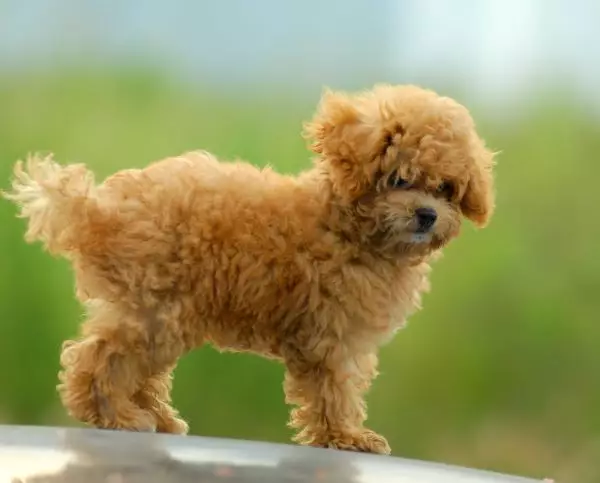

Predictions for shutterstock_39949891_ed-close-shoot-small-brown-toy-poodle-with-green-background.webp:
n02113624-toy_poodle           89.12%
n02113712-miniature_poodle     10.49%
n02112137-chow                 0.13%
n02086079-Pekinese             0.05%
n02096437-Dandie_Dinmont       0.04%


In [9]:
eval_transform = T.Compose([
    T.Resize(int(160 * 1.14)),
    T.CenterCrop(160),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

idx_to_class = {v: k for k, v in checkpoint["class_to_idx"].items()}

image_path = "/home/tobyvdp/Pictures/shutterstock_39949891_ed-close-shoot-small-brown-toy-poodle-with-green-background.webp"

if image_path != "":
    img = Image.open(image_path).convert('RGB')
    display(img)
    tensor = eval_transform(img)

    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1)
    
    k = 5
    top_probs, top_indices = torch.topk(probs, k)
    
    top_probs = top_probs.squeeze().tolist()
    top_indices = top_indices.squeeze().tolist()
    
    print(f"Predictions for {Path(image_path).name}:")
    for prob, idx in zip(top_probs, top_indices):
        class_name = idx_to_class[idx]
        print(f"{class_name:<30} {prob * 100:.2f}%")